# Datetime String Parsing/Formatting
## Research Questions
**What are the most common string formats used for datetimes?**

The most common formats for formatting strings are ISO compliant. Among format-dependant functions (formatters or format-dependant parsers) `.isoformat` makes up 13.97% of the total count while the two most common format strings `'%Y-%m-%d` and `%Y-%m-%d %H:%M:%S` make up 8.48% and 7.03% of the count respectively. Format strings become much more varied from there with the next most common format `%Y%m%d` only accounting for 2.55%. Another interesting format is `.ctime()`, a much more human readable format, which represents 6.13% of the data.

**How often do people follow standards vs. use their own formats?**

By far the most common function calls which deal with formatting/parsing are `stftime` and `strptime` which account for 72.46% of all functions found. However, the format string which people use with these methods actually *are* often ISO compliant, as mentioned above. In `strftime`, 19.99% of format strings use ISO 8601 and an additional 15.63% use a slightly modified version of ISO 8601 (replacing the "T" with some other character - often a space). In `strptime`, 37.13% use pure ISO 8601 and 17.26% use a modified version.

**How often do people use format agnostic parsers?**
 * How often are there bugs related to unclear date formats?
 * These are hard to detect because most of them are just named "parse"

**How consistent are people with formats within a single project?**

About 64.31% of repos only use one pattern (e.g. only `strftime`), 22.79% use two, and 12.90% use three or more.

**How much intention are people putting into their formats?**
 * Not quantifiable at all
 * strftime vs builtins
 * "least resistance methods" like `str()` or format strings.
 
**How often do people store timezone information in their format strings?**

Only 5.92% of format strings include a format directive to include the timezone, and another 3.98% hard code in a timezone (most often "Z").
 
## Issues with the current scripts
 * Hard to detect `from a import b; b()`. Most `parse` methods fall under this category.
 * Not currently distinguishing between `time.strftime` and `datetime.strftime`.
 * Can't properly handle multiline calls.
 * Can't properly handle format constants e.g. `FORMAT = '%Y%m%d'; dt.strftime(FORMAT)`.
 * False positives on comments mentioning method names.
 * Doesn't detect str() or format strings
 * Can accidentally capture substring such as matching `utctimestamp` with `/ctime/`.

In [1]:
%pip install pandas
%pip install numpy
# %pip install seaborn

import pandas as pd
import math
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import re


# Read the data from the CSV file
# STRING_OPS_PATH = '/data/petervan/date-time/data/string_operations.csv'
# to work with the data locally, use a command like:
# scp petervan@bucatini.isri.cmu.edu:/data/petervan/date-time/data/string_operations.csv string_operations.csv
STRING_OPS_PATH = 'string_operations.csv'
df = pd.read_csv(STRING_OPS_PATH)
print(len(df))
df

# df[["owner", "repo", "path", "line", "operation", "text"]].to_csv(STRING_OPS_PATH, index=False)

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
126740


,owner,repo,path,line,operation,pattern,text
0,mkdocs,mkdocs,mkdocs:mkdocs/mkdocs/utils/__init__.py,83,format,strftime,return get_build_datetime().strftime('%Y-%...
1,mkdocs,mkdocs,mkdocs:mkdocs/mkdocs/livereload/__init__.py,79,format,strftime,"return time.strftime(""[%H:%M:%S] "") + ..."
2,prompt-toolkit,python-prompt-toolkit,examples/full-screen/text-editor.py,231,format,isoformat,text = datetime.datetime.now().isoformat()
3,prompt-toolkit,python-prompt-toolkit,examples/prompts/fancy-zsh-prompt.py,56,format,isoformat,") % (datetime.datetime.now().isoformat(),)"
4,nylas,sync-engine,inbox/api/kellogs.py,96,format,isoformat,return obj.isoformat()
...,...,...,...,...,...,...,...
126735,togethercomputer,MoA,FastChat/fastchat/serve/monitor/dataset_releas...,66,format,strftime,"datetime.datetime.fromtimestamp(x, tz=time..."
126736,jishengpeng,ControlSpeech,baseline/promptTTS/utils/commons/trainer.py,545,format,strftime,t = datetime.now().strftime('%Y%m%d%H%...
126737,jishengpeng,ControlSpeech,baseline/promptTTS/utils/commons/trainer.py,551,format,strftime,t = datetime.now().strftime('%Y%m%...
126738,jishengpeng,ControlSpeech,baseline/promptTTS/mfa_usr/mfa.py,477,format,strftime,execution_time = time....


In [16]:
# HELPER FUNCTIONS
# get_even_colors was made by me
# heatmap and annotate_heatmap are from https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

def get_even_colors(cmap, n):
    if type(cmap) == str:
        cmap = matplotlib.colormaps[cmap]
    return [cmap(i/(n))for i in range(n)]

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

('MyEMS', 'myems') 2485


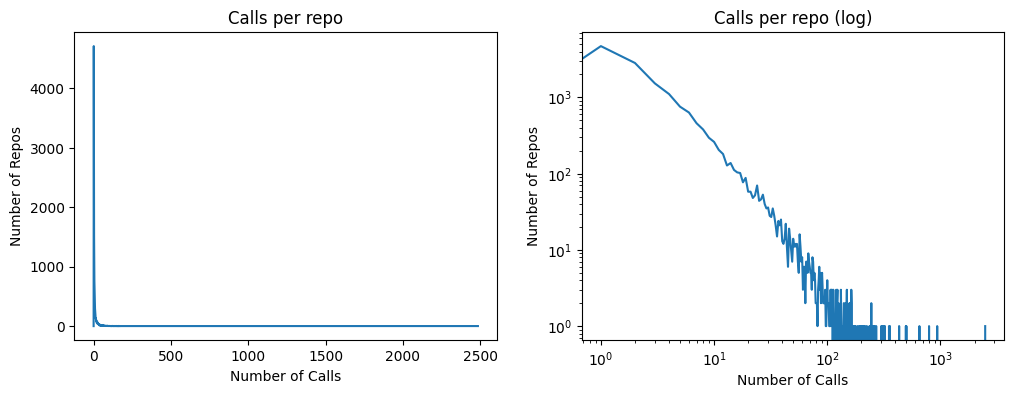

In [3]:
# What is the distribution of number of calls per repo

counter = dict()
for i, row in df.iterrows():
    counter[(row["owner"], row["repo"])] = counter.get((row["owner"], row["repo"]), 0) + 1

maxcount = max(list(counter.values()))
for repo in counter:
    if counter[repo] == maxcount:
        print(repo, maxcount)

count_dist = [0] * (maxcount+1)

for v in counter.values():
    count_dist[v] += 1

# plot

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.set_title("Calls per repo")
ax.set_xlabel("Number of Calls")
ax.set_ylabel("Number of Repos")
ax.plot(range(maxcount+1), count_dist)

ax = fig.add_subplot(122)
ax.set_title("Calls per repo (log)")
ax.set_xlabel("Number of Calls")
ax.set_ylabel("Number of Repos")
ax.plot(range(maxcount+1), count_dist)
ax.set_xscale('log')
ax.set_yscale('log')

15395
('airbytehq', 'airbyte') 8
[0, 9900, 3509, 1393, 473, 107, 12, 0, 1]


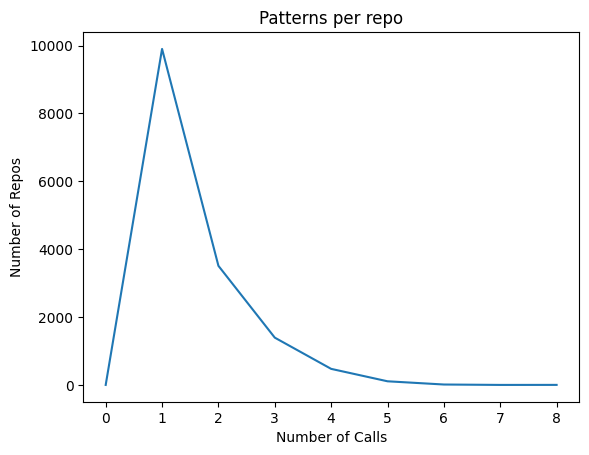

In [34]:
# what is the distribution of the number of patterns per repo
uniques = df.drop_duplicates(subset = ["owner", "repo", "pattern"]) 
print(len(df.drop_duplicates(subset = ["owner", "repo"])))

counter = dict()
for i, row in uniques.iterrows():
    counter[(row["owner"], row["repo"])] = counter.get((row["owner"], row["repo"]), 0) + 1

maxcount = max(list(counter.values()))
for repo in counter:
    if counter[repo] == maxcount:
        print(repo, maxcount)

count_dist = [0] * (maxcount+1)

for v in counter.values():
    count_dist[v] += 1

# plot

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Patterns per repo")
ax.set_xlabel("Number of Calls")
ax.set_ylabel("Number of Repos")
ax.plot(range(maxcount+1), count_dist)
print(count_dist)

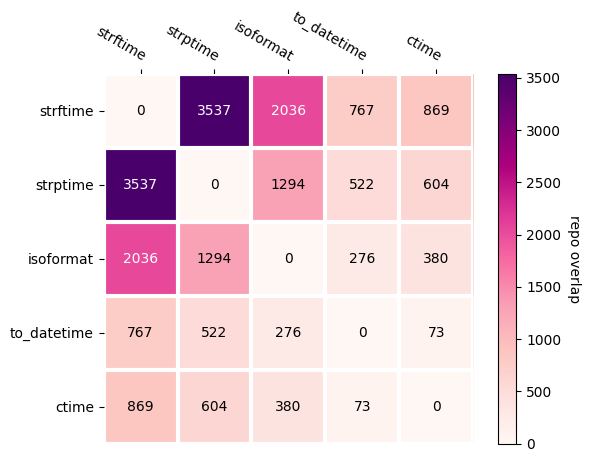

In [32]:
# How common are each combination of patterns

# patterns, counts = np.unique(df["pattern"], return_counts=True)
# counts, patterns = zip(*sorted(list(zip(counts, patterns)), reverse=True))
# patterns = list(patterns)
patterns = ["strftime", "strptime", "isoformat", "to_datetime", "ctime"]
corr = np.zeros((len(patterns), len(patterns)))
# corr[a][b] is the number of repos where patterns a and b both appear

repopatterns = {}
for i, row in uniques.iterrows():
    repoid = row["owner"]+"+"+row["repo"]
    if repoid not in repopatterns:
        repopatterns[repoid] = set()
    repopatterns[repoid].add(row["pattern"])

for repoid in repopatterns:
    for i,p1 in enumerate(patterns):
        for j,p2 in enumerate(patterns):
            if p1 in repopatterns[repoid] and p2 in repopatterns[repoid] and p1 != p2:
                corr[i][j] += 1

fig = plt.figure()
ax = fig.add_subplot(111)

im, cbar = heatmap(corr, patterns, patterns, ax=ax,
                   cmap="RdPu", cbarlabel="repo overlap")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

# fig.tight_layout()
plt.show()

# TODO: represent expected values assuming no correlation between variables

In [ ]:
# What is the distribution of operations
categories, counts = np.unique(df["operation"], return_counts=True)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Formatting vs Parsing")
colors = get_even_colors("twilight", 3)
ax.pie(x=counts, labels=categories, colors = colors, autopct="%.4g")
ax.legend()

((19, 276, 280, 1455, 1485, 7049, 8292, 16048, 21741, 70095),
 ('maya.parse',
  'dateparser.parse',
  'pendulum.parse',
  'arrow.get',
  'dateutil.parser.parse',
  'ctime',
  'to_datetime',
  'isoformat',
  'strptime',
  'strftime'))

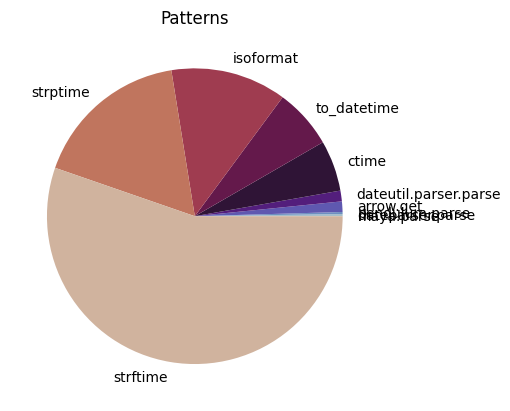

In [9]:
# What is the distribution of patterns
patterns, counts = np.unique(df["pattern"], return_counts=True)
counts, patterns = zip(*sorted(list(zip(counts, patterns))))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Patterns")
colors = get_even_colors("twilight", len(patterns))
ax.pie(x=counts, labels=categories, colors = colors)
counts, categories
# ax.legend(loc="upper right")

In [ ]:
for count, cat in zip(counts, categories):
    print(cat, count, count/(sum(counts)))

## Finding common string formats
For now I'm only going to consider the following patterns:
 * `strftime` (datetime and time)
 * `strptime` (datetime and time)
 * `ctime`
 * `isoformat`
 
These make up around 90% of the table, and make up basically all of the patterns that use formats (i.e. aren't format agnostic parsers).

In [ ]:
filtered_df = df[df["pattern"].isin(["strftime", "strptime", "ctime", "isoformat"])]
print(len(filtered_df) / len(df))
print(len(filtered_df))

In [ ]:
# first, strftime formats because they're easiest to parse
pattern = "strftime\\(\\s*[\"\'](.*?)[\"\']\\s*\\)"
print(pattern)
strf_counts = dict()
for i,row in df.iterrows():
    if row["pattern"] == "strftime":
        match = re.search(pattern, row["text"])
        if match is not None:
            strf_counts[match.group(1)] = strf_counts.get(match.group(1), 0) + 1

print(sum(strf_counts.values()))
sorted_strf_counts = sorted(list(zip(strf_counts.values(), strf_counts.keys())), reverse=True)
for i in range(10):
    print(sorted_strf_counts[i])

In [ ]:
# strptime should be the same with a slightly longer regex
pattern = "strptime\\(.*?,\\s*[\"\'](.*?)[\"\']\\s*\\)"
print(pattern)
strp_counts = dict()
for i,row in df.iterrows():
    if row["pattern"] == "strptime":
        match = re.search(pattern, row["text"])
        if match is not None:
            strp_counts[match.group(1)] = strp_counts.get(match.group(1), 0) + 1

sorted_strp_counts = sorted(list(zip(strp_counts.values(), strp_counts.keys())), reverse=True)
for i in range(10):
    print(sorted_strp_counts[i])

In [ ]:
# how ISO compliant are these format strings?
# It's weirdly hard to find a summary of ISO 8601 online or even a full version that doesn't cost >$100
# this is what I'm going off of https://www.w3.org/TR/NOTE-datetime
# 
def is_iso(fmt):
    components = ["%Y", "-%m", "-%d", "T", "%H", ":%M", ":%S", "\\.%f"]
    tzs = ["", "Z", "%:z"]
    for component in components:
        match = re.match(component, fmt)
        if match is None:
            return False
        else:
            fmt = fmt[match.end():]
        
        if fmt in tzs:
            return True
    return False

def is_almost_iso(fmt):
    components = ["%Y", "-%m", "-%d", ".", "%H", ":%M", ":%S", "\\.%f"]
    tzs = ["", "Z", "%:z"]
    for component in components:
        match = re.match(component, fmt)
        if match is None:
            return False
        else:
            fmt = fmt[match.end():]
        
        if fmt in tzs:
            return True
    return False
    
assert is_iso("%Y-%m-%dT%H")
assert not is_iso("%Y-%m-%d %H")
assert is_almost_iso("%Y-%m-%d %H")
assert not is_iso("%Y-%m-%d %H%M%S")
assert not is_iso("%Y-%m-%d %H:%")
assert not is_iso("%Y-%m-%d %H:%M:%S.%fffffffffff")

In [ ]:
labels = ["ISO Compliant", "Semi-compliant", "Noncompliant"]
strf_x = [0,0,0]
strp_x = [0,0,0]

for (count,fmt) in sorted_strf_counts:
    if is_iso(fmt):
        strf_x[0] += count
    elif is_almost_iso(fmt):
        strf_x[1] += count
    else:
        strf_x[2] += count

for (count,fmt) in sorted_strp_counts:
    if is_iso(fmt):
        strp_x[0] += count
    elif is_almost_iso(fmt):
        strp_x[1] += count
    else:
        strp_x[2] += count

    
fig = plt.figure(figsize=(12,4))
colors = get_even_colors("twilight", 3)

ax = fig.add_subplot(121)
ax.set_title("ISO compliance in strftime")
ax.pie(x=strf_x, labels=labels, colors = colors)
print(strf_x, sum(strf_x))

ax = fig.add_subplot(122)
ax.set_title("ISO compliance in strptime")
ax.pie(x=strp_x, labels=labels, colors = colors)
print(strp_x, sum(strp_x))

"" 

In [ ]:
# how often do people use each format directive
real_directives = ['%a', '%A', '%w', '%d', '%b', '%B', '%m', '%y', '%Y', '%H', '%I', '%p', '%M', '%S', '%f', '%z', '%Z', '%j', '%U', '%W', '%c', '%x', '%X', '%G', '%u', '%V', '%:z', '%%']
directives = {}
for (count, fmt) in sorted_strf_counts + sorted_strp_counts:
    for i in range(len(fmt)-1):
        if fmt[i] == "%":
            directive = fmt[i:i+2]
            directives[directive] = directives.get(directive,0)+1
sorted_directives = sorted(list(zip(directives.values(), directives.keys())), reverse=True)
for count,d in sorted_directives:
    if d in real_directives:
        print(f"{d}: {count}")
    else:
        print(f"{d}: {count:<10} (invalid)")

In [ ]:
# how often do people include timezone information in their format strings
# just checking for "z" actually seems pretty good because they're either
# * using Z because the datetime is always going to be UTC
# * using %Z, %z or %:z which records the timezone of the datetime
# * using a word which contains "z" in it, which is very unlikely
tzcount = 0
hardtzcount = 0
nontzcount = 0
for count,d in sorted_strf_counts + sorted_strp_counts:
    if "%z" in d.lower() or "%:z" in d:
        tzcount += 1
    elif "Z" in d or re.search("\+\d\d(:|)\d\d", d) is not None:
        hardtzcount += 1
    else:
        nontzcount += 1

print(f"{tzcount}, {100*tzcount/(nontzcount+tzcount+hardtzcount):.4}%")
print(f"{hardtzcount}, {100*hardtzcount/(nontzcount+tzcount+hardtzcount):.4}%")
print(f"{nontzcount}, {100*nontzcount/(nontzcount+tzcount+hardtzcount):.4}%")